<a href="https://colab.research.google.com/github/sreekrishna7/COVID_19_Prediction_Analysis/blob/master/JohnHopkins_CSSE_COVID_19_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [35]:
from __future__ import absolute_import, division, print_function, unicode_literals 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
import datetime
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

In [36]:
# Read the data from repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)
US_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
US_deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')


In [37]:
drop_list = ['UID',	'iso2',	'iso3',	'code3',	'FIPS', 'Lat', 'Long_', 'Combined_Key']
US_confirmed_df = US_confirmed_df.drop(drop_list, axis=1)
US_deaths_df =  US_deaths_df.drop(drop_list, axis=1) # containes an additional column with population data


In [38]:
# Dates to visualize
start_date  = '2/22/20' 
end_date    = '8/20/20'
dates = US_confirmed_df.loc[:, start_date:end_date].columns
start2end_dates = pd.DatetimeIndex(dates)
days_start2end = np.array([i for i in range(len(start2end_dates))]).reshape(-1, 1)


In [39]:
#Future forecast
days_in_future = 10
days_start2future = np.array([i for i in range(len(start2end_dates)+days_in_future)]).reshape(-1, 1)
start2future_dates = pd.date_range(start=start_date, periods=len(start2end_dates)+days_in_future)

In [40]:
start2end_dates_array = []
for i in range(len(days_start2end)):
    start2end_dates_array.append(start2end_dates[i])
start2future_dates_array = []
for i in range(len(days_start2future)):
    start2future_dates_array.append(start2future_dates[i])

In [41]:
states_confirmed_df = US_confirmed_df.groupby('Province_State')[dates].sum().transpose()
states_deaths_df    = US_deaths_df.groupby('Province_State')[dates].sum().transpose()
states_confirmed_df.set_index(start2end_dates, inplace=True)
states_deaths_df.set_index(start2end_dates, inplace=True)

In [42]:
states_confirmed_df.tail(10)

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-08-11,103851,3819,0,188737,50411,578946,51422,50684,15699,49,12896,542792,222588,103,449,3756,25598,198248,75862,49521,31468,35793,133125,4052,96843,121707,98213,61839,68293,61440,5104,29030,57520,6861,185475,22643,422003,138743,7885,49,102826,44728,21774,125016,23403,20053,102130,9713,124915,517700,44752,1472,576,101745,64151,7879,61785,3073
2020-08-12,104786,3879,0,189443,51096,591376,51737,50706,15765,49,12959,550901,226153,103,449,3958,26134,199893,76522,49973,32097,36945,134304,4070,97384,122000,98689,62303,69374,62956,5268,29244,58048,6887,185938,22816,422703,139739,7970,49,104248,45398,22022,125918,24074,20129,102974,9815,126393,523977,45090,1478,639,102521,64702,8018,62263,3086
2020-08-13,105557,3963,0,190794,51766,597984,52200,50782,15967,49,13024,557137,228668,103,477,4312,26629,201727,77565,50373,32484,37686,135439,4089,98160,122423,99856,62993,69986,64429,5407,29660,58650,6921,186594,22987,423440,140824,8171,49,105426,46103,22300,126905,24446,20240,103909,9897,128511,530857,45424,1484,682,103622,65339,8163,63206,3119
2020-08-14,106309,4073,0,191721,52392,613101,52519,50897,16340,49,13118,563285,231895,103,502,4543,27171,204023,78632,51247,33030,38298,136737,4116,98875,122728,100724,63723,70930,65793,5541,29988,59749,6964,187164,23160,424167,142170,8322,50,106557,46897,22613,127732,25128,20335,104841,10024,130458,539673,45976,1501,704,104838,66139,8277,64227,3183
2020-08-15,107580,4156,0,192654,51992,617994,52819,50897,16396,49,13159,569637,235168,103,502,4825,27475,205851,79676,52065,33885,38930,136737,4144,99693,123199,101782,64413,71755,67004,5659,30241,60608,6980,187442,23302,424901,143704,8444,50,107674,47798,23018,128531,25695,20335,105882,10118,131747,546552,46321,1509,734,105750,66885,8462,65056,3227
2020-08-16,108433,4259,0,193537,52665,623873,53157,50897,16451,49,13220,573416,237030,103,502,5042,27656,207412,80415,52447,33885,38930,137918,4168,100212,123593,102259,65152,72136,68196,5750,30372,61305,6988,187455,23408,425508,144952,8587,50,108287,48342,23262,129070,26006,20335,106497,10274,133708,555394,46652,1515,741,106687,67461,8567,65741,3286
2020-08-17,109004,4309,0,194005,53077,629415,53351,51267,16536,49,13273,576094,238861,103,577,5215,27937,209185,81006,52829,34614,39691,138485,4197,100715,123841,102749,65716,72412,69225,5792,30563,61967,7004,187767,23500,425916,145516,8647,54,109062,48711,23451,129647,26760,20572,106953,10360,134744,561110,46894,1527,760,107421,67721,8641,66196,3331
2020-08-18,110361,4371,0,194920,53487,638140,53612,51255,16593,49,13325,579932,241677,103,599,5349,28321,210924,81847,53201,34874,40299,139125,4213,101235,124063,103402,66092,73207,70055,5846,30825,62639,7017,188098,23579,426571,146779,8782,54,109910,49312,23676,130247,27713,20692,107672,10441,135770,568812,47157,1530,796,108282,68263,8738,66196,3360
2020-08-19,111478,4438,0,195557,54216,647274,53882,51314,16643,49,13354,584047,243982,103,599,5609,28680,213220,82336,53523,35419,40926,139903,4235,101649,124415,104091,66618,74555,71285,5956,31040,63028,7036,188427,23749,427202,147925,8968,54,110881,49923,23870,130905,27934,20795,108411,10566,137800,574633,47521,1533,828,109019,68689,8807,67493,3431
2020-08-20,112449,4520,0,196280,54765,652267,54211,51432,16718,49,13409,588602,246741,103,704,5844,29110,215052,83277,54533,35907,41626,140821,4253,102229,124728,104618,67308,75449,72353,6072,31348,63584,7050,188527,23951,

In [43]:
states_deaths_df.tail(8)

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-08-13,1890,27,0,4383,582,10870,1882,4450,593,0,594,8913,4538,3,5,40,251,7905,3105,960,403,796,4402,126,3620,8790,6555,1731,2011,1356,81,360,1030,422,15893,697,32805,2287,120,2,3755,638,383,7395,306,1019,2184,148,1313,9771,353,58,9,2363,1736,153,1018,30
2020-08-14,1893,27,0,4423,587,11148,1888,4453,593,0,594,9141,4573,3,5,40,265,7932,3113,970,404,804,4430,126,3631,8810,6566,1739,2043,1365,81,361,1045,423,15903,703,32827,2313,121,2,3784,644,385,7434,317,1021,2204,150,1326,10078,360,58,9,2370,1755,157,1025,30
2020-08-15,1896,28,0,4492,600,11218,1896,4453,593,0,597,9345,4669,3,5,40,269,7937,3128,975,406,810,4430,127,3636,8826,6586,1705,2080,1378,82,361,1069,423,15910,711,32833,2343,121,2,3824,657,386,7451,329,1021,2260,152,1345,10268,363,58,9,2381,1766,160,1038,30
2020-08-16,1898,28,0,4506,599,11243,1896,4453,593,0,597,9452,4702,3,5,40,269,7955,3133,975,406,810,4507,127,3639,8838,6592,1752,2084,1383,82,361,1072,423,15912,714,32840,2347,125,2,3826,661,388,7453,335,1021,2269,153,1366,10396,363,58,9,2381,1781,160,1039,30
2020-08-17,1925,28,0,4506,603,11296,1896,4456,593,0,597,9539,4727,3,5,40,273,7967,3135,987,406,818,4526,127,3641,8842,6592,1758,2095,1415,82,362,1077,423,15916,718,32846,2348,126,2,3832,665,388,7453,335,1023,2288,153,1387,10447,364,58,9,2385,1785,160,1039,30
2020-08-18,1936,29,0,4529,619,11504,1899,4456,593,0,599,9758,4794,3,5,41,282,7994,3165,1002,411,830,4554,127,3650,8848,6608,1767,2127,1425,84,369,1102,424,15925,723,32857,2396,128,2,3866,679,397,7474,346,1024,2343,154,1424,10678,369,58,9,2396,1808,162,1039,30
2020-08-19,1944,29,0,4634,631,11690,1900,4457,595,0,600,9932,4849,3,5,42,289,8017,3180,1010,415,842,4609,127,3661,8876,6618,1784,2163,1434,84,371,1134,427,15926,729,32865,2431,130,2,3907,699,408,7508,356,1027,2360,155,1452,10934,377,58,9,2410,1822,166,1060,34
2020-08-20,1974,29,0,4684,641,11810,1903,4458,595,0,601,10049,4904,3,6,45,296,8044,3191,1016,419,856,4637,128,3669,8888,6634,1791,2190,1442,89,373,1172,428,15932,734,32861,2465,130,2,3929,709,412,7520,367,1028,2401,157,1488,11174,381,58,10,2427,1837,167,1067,34


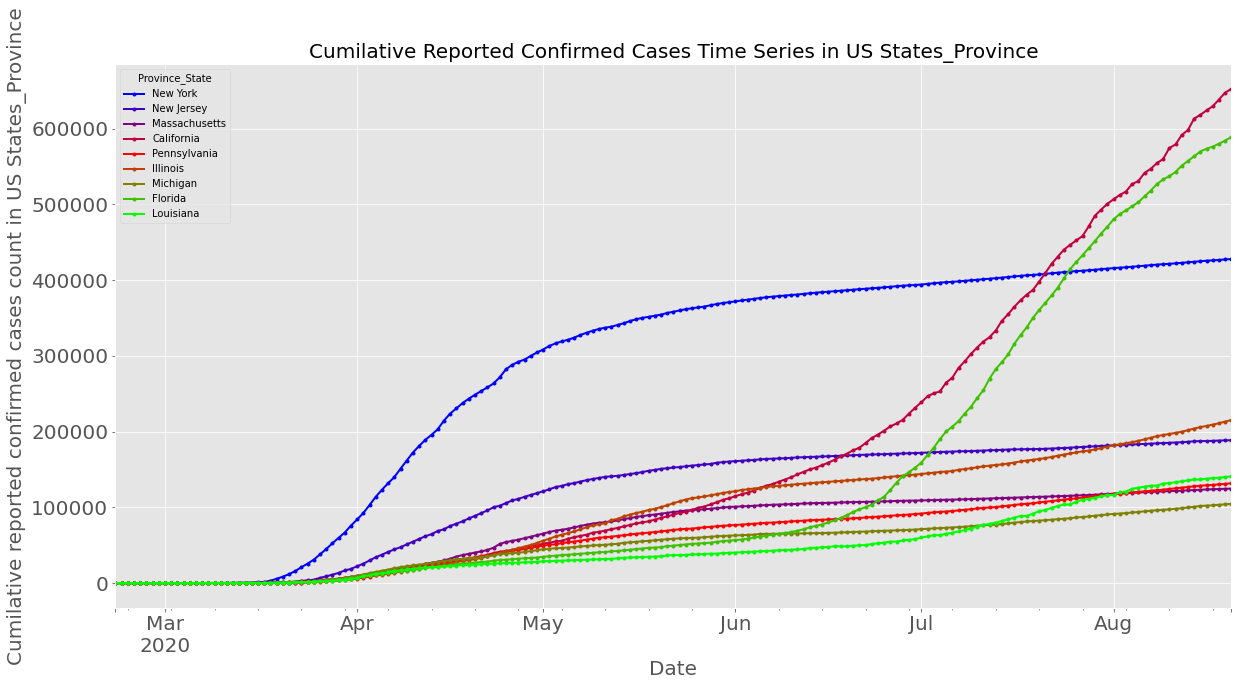

In [44]:
# Plot graphs for states of interest
soi = ['New York', 'New Jersey', 'Massachusetts', 'California', 'Pennsylvania', 'Illinois', 'Michigan', 'Florida', 'Louisiana']
states_confirmed_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Cumilative reported confirmed cases count in US States_Province', fontsize=20);
plt.title('Cumilative Reported Confirmed Cases Time Series in US States_Province', fontsize=20);                           

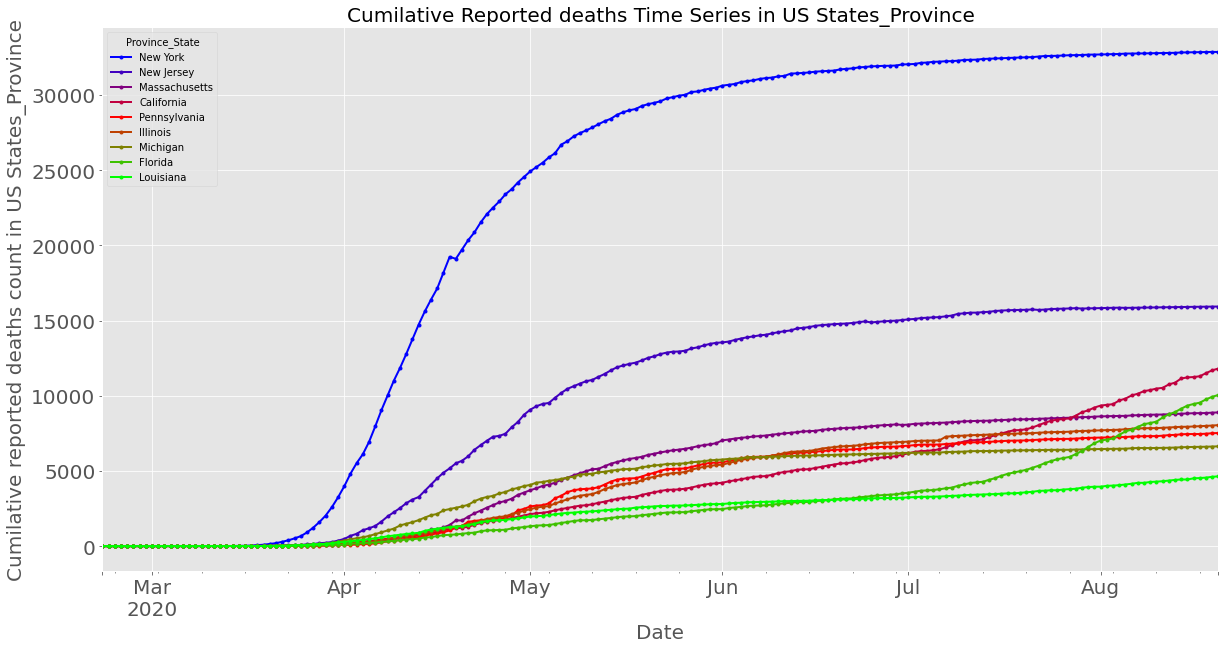

In [45]:
states_deaths_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Cumilative reported deaths count in US States_Province', fontsize=20);
plt.title('Cumilative Reported deaths Time Series in US States_Province', fontsize=20);

In [46]:
# manually correct the abnormal data
#states_deaths_df.loc['2020-04-24','New York']=(states_deaths_df.loc['2020-04-23','New York'] + states_deaths_df.loc['2020-04-25','New York'])/2


In [47]:
states_daily_confirmed_df = states_confirmed_df.diff()
states_daily_confirmed_df 

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,853.0,103.0,0.0,883.0,673.0,5879.0,338.0,0.0,55.0,0.0,61.0,3779.0,1862.0,0.0,0.0,217.0,181.0,1561.0,739.0,382.0,0.0,0.0,1181.0,24.0,519.0,394.0,477.0,739.0,381.0,1192.0,91.0,131.0,697.0,8.0,13.0,106.0,607.0,1248.0,143.0,0.0,613.0,544.0,244.0,539.0,311.0,0.0,615.0,156.0,1961.0,8842.0,331.0,6.0,7.0,937.0,576.0,105.0,685.0,59.0
2020-08-17,571.0,50.0,0.0,468.0,412.0,5542.0,194.0,370.0,85.0,0.0,53.0,2678.0,1831.0,0.0,75.0,173.0,281.0,1773.0,591.0,382.0,729.0,761.0,567.0,29.0,503.0,248.0,490.0,564.0,276.0,1029.0,42.0,191.0,662.0,16.0,312.0,92.0,408.0,564.0,60.0,4.0,775.0,369.0,189.0,577.0,754.0,237.0,456.0,86.0,1036.0,5716.0,242.0,12.0,19.0,734.0,260.0,74.0,455.0,45.0
2020-08-18,1357.0,62.0,0.0,915.0,410.0,8725.0,261.0,-12.0,57.0,0.0,52.0,3838.0,2816.0,0.0,22.0,134.0,384.0,1739.0,841.0,372.0,260.0,608.0,640.0,16.0,520.0,222.0,653.0,376.0,795.0,830.0,54.0,262.0,672.0,13.0,331.0,79.0,655.0,1263.0,135.0,0.0,848.0,601.0,225.0,600.0,953.0,120.0,719.0,81.0,1026.0,7702.0,263.0,3.0,36.0,861.0,542.0,97.0,0.0,29.0
2020-08-19,1117.0,67.0,0.0,637.0,729.0,9134.0,270.0,59.0,50.0,0.0,29.0,4115.0,2305.0,0.0,0.0,260.0,359.0,2296.0,489.0,322.0,545.0,627.0,778.0,22.0,414.0,352.0,689.0,526.0,1348.0,1230.0,110.0,215.0,389.0,19.0,329.0,170.0,631.0,1146.0,186.0,0.0,971.0,611.0,194.0,658.0,221.0,103.0,739.0,125.0,2030.0,5821.0,364.0,3.0,32.0,737.0,426.0,69.0,1297.0,71.0


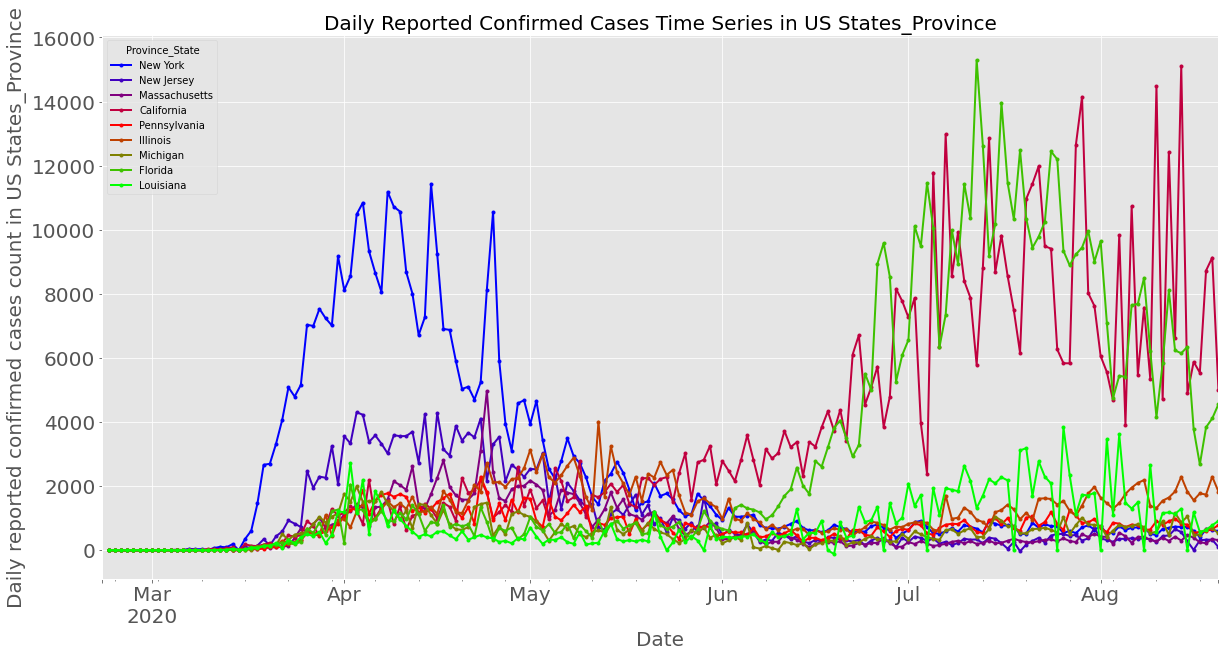

In [48]:
states_daily_confirmed_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily reported confirmed cases count in US States_Province', fontsize=20);
plt.title('Daily Reported Confirmed Cases Time Series in US States_Province', fontsize=20);  

In [49]:
states_daily_deaths_df = states_deaths_df.diff()
states_daily_deaths_df.tail()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-08-16,2.0,0.0,0.0,14.0,-1.0,25.0,0.0,0.0,0.0,0.0,0.0,107.0,33.0,0.0,0.0,0.0,0.0,18.0,5.0,0.0,0.0,0.0,77.0,0.0,3.0,12.0,6.0,47.0,4.0,5.0,0.0,0.0,3.0,0.0,2.0,3.0,7.0,4.0,4.0,0.0,2.0,4.0,2.0,2.0,6.0,0.0,9.0,1.0,21.0,128.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0
2020-08-17,27.0,0.0,0.0,0.0,4.0,53.0,0.0,3.0,0.0,0.0,0.0,87.0,25.0,0.0,0.0,0.0,4.0,12.0,2.0,12.0,0.0,8.0,19.0,0.0,2.0,4.0,0.0,6.0,11.0,32.0,0.0,1.0,5.0,0.0,4.0,4.0,6.0,1.0,1.0,0.0,6.0,4.0,0.0,0.0,0.0,2.0,19.0,0.0,21.0,51.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
2020-08-18,11.0,1.0,0.0,23.0,16.0,208.0,3.0,0.0,0.0,0.0,2.0,219.0,67.0,0.0,0.0,1.0,9.0,27.0,30.0,15.0,5.0,12.0,28.0,0.0,9.0,6.0,16.0,9.0,32.0,10.0,2.0,7.0,25.0,1.0,9.0,5.0,11.0,48.0,2.0,0.0,34.0,14.0,9.0,21.0,11.0,1.0,55.0,1.0,37.0,231.0,5.0,0.0,0.0,11.0,23.0,2.0,0.0,0.0
2020-08-19,8.0,0.0,0.0,105.0,12.0,186.0,1.0,1.0,2.0,0.0,1.0,174.0,55.0,0.0,0.0,1.0,7.0,23.0,15.0,8.0,4.0,12.0,55.0,0.0,11.0,28.0,10.0,17.0,36.0,9.0,0.0,2.0,32.0,3.0,1.0,6.0,8.0,35.0,2.0,0.0,41.0,20.0,11.0,34.0,10.0,3.0,17.0,1.0,28.0,256.0,8.0,0.0,0.0,14.0,14.0,4.0,21.0,4.0
2020-08-20,30.0,0.0,0.0,50.0,10.0,120.0,3.0,1.0,0.0,0.0,1.0,117.0,55.0,0.0,1.0,3.0,7.0,27.0,11.0,6.0,4.0,14.0,28.0,1.0,8.0,12.0,16.0,7.0,27.0,8.0,5.0,2.0,38.0,1.0,6.0,5.0,-4.0,34.0,0.0,0.0,22.0,10.0,4.0,12.0,11.0,1.0,41.0,2.0,36.0,240.0,4.0,0.0,1.0,17.0,15.0,1.0,7.0,0.0


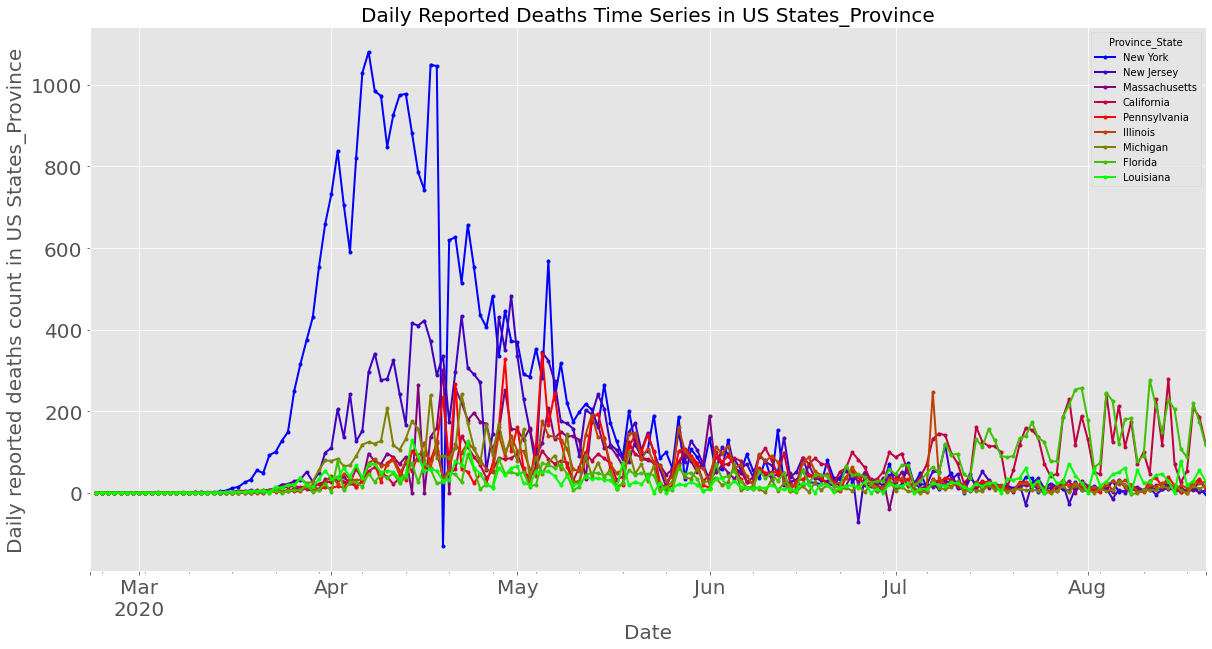

In [50]:
states_daily_deaths_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily reported deaths count in US States_Province', fontsize=20);
plt.title('Daily Reported Deaths Time Series in US States_Province', fontsize=20);  

In [51]:
# There is no daily recovery data available.
# Here is the statement from louisisan governors office: "“because most people who are sick recover at home. A person is considered recovered when it has been at least seven days after the onset of illness, AND at least three days after resolution of fever and resolution or improvement in respiratory symptoms.” 
# Read More: Here's Why Louisiana Says They Can't Report COVID Recovery Number | https://710keel.com/heres-why-louisiana-says-they-cant-report-covid-recovery-numbers/?utm_source=tsmclip&utm_medium=referral"

# Therefore creating dataframe with an estimate of recovery data
# Number of recoveries until today= number of confirmed cases until seven days prior - Number of deaths until today
states_recovery_df = pd.DataFrame(index=states_confirmed_df.index, columns =states_confirmed_df.columns) # creating empty data frame of same size
for i in range(len(states_recovery_df)-7):
  states_recovery_df.iloc[i+7] = states_confirmed_df.iloc[i] - states_deaths_df.iloc[i+7]
states_recovery_df

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,99436,3683,0,182417,48784,548503,48746,45867,14982,49,12156,523354,211894,100,413,3458,24406,187425,71195,47944,30256,34172,126892,3917,91864,112202,90134,59146,65089,58000,4870,28071,55158,6412,168861,21601,388020,133999,7471,46,97022,42905,20884,115859,21786,18717,98166,9452,121346,492932,43764,1401,519,97705,61291,7535,59515,3020
2020-08-17,101095,3746,0,183017,49425,562935,49124,46111,15041,49,12210,527422,214298,100,413,3598,24831,188732,71857,48178,30777,34436,127435,3924,92617,112473,90714,59758,65554,58944,4935,28334,55895,6417,169115,21726,388490,135214,7587,47,97899,43298,21100,116768,22486,18911,98871,9510,122527,499134,44026,1404,538,98364,61862,7597,60022,3012
2020-08-18,101915,3790,0,184208,49792,567442,49523,46228,15106,49,12297,533034,217794,100,444,3715,25316,190254,72697,48519,31057,34963,128571,3925,93193,112859,91605,60072,66166,60015,5020,28661,56418,6437,169550,21920,389146,136347,7757,47,98960,44049,21377,117542,23057,19029,99787,9559,123491,507022,44383,1414,567,99349,62343,7717,60746,3043
2020-08-19,102842,3850,0,184809,50465,579686,49837,46249,15170,49,12359,540969,221304,100,444,3916,25845,191876,73342,48963,31682,36103,129695,3943,93723,113124,92071,60519,67211,61522,5184,28873,56914,6460,170012,22087,389838,137308,7840,47,100341,44699,21614,118410,23718,19102,100614,9660,124941,513043,44713,1420,630,100111,62880,7852,61203,3052


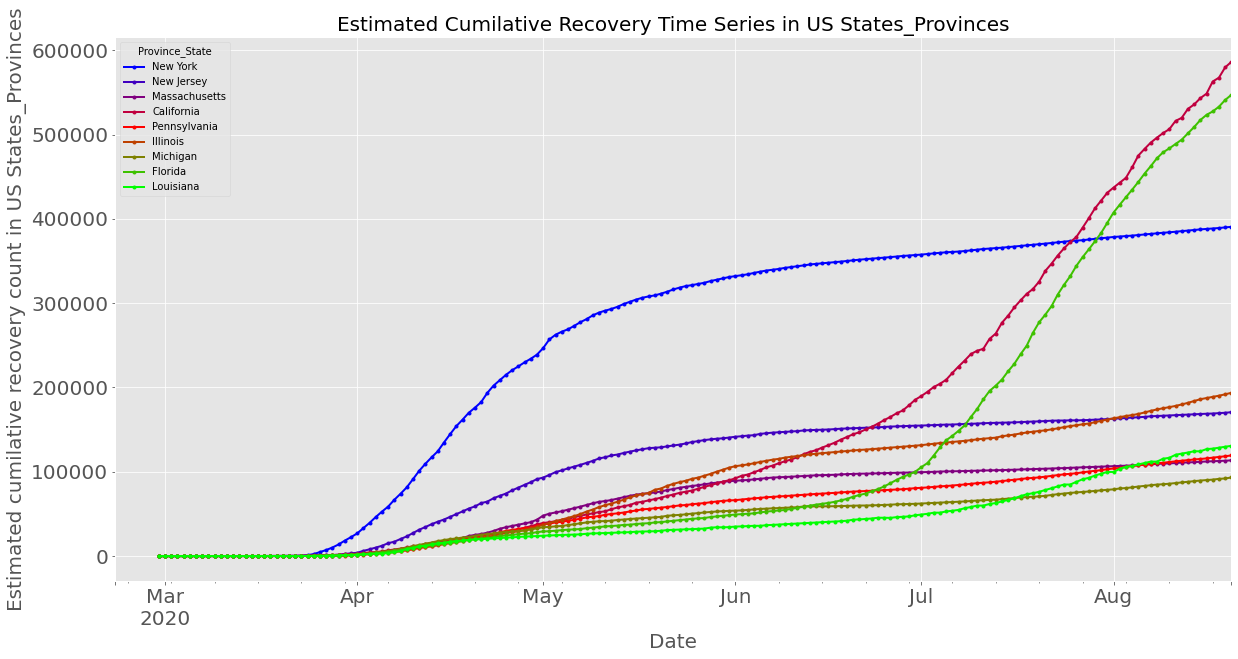

In [52]:
states_recovery_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Estimated cumilative recovery count in US States_Provinces', fontsize=20);
plt.title('Estimated Cumilative Recovery Time Series in US States_Provinces', fontsize=20);  

In [53]:
states_daily_recovery_df = states_recovery_df.diff()
states_daily_recovery_df 

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,1159,98,0,802,573,5333,336,0,73,0,100,6122,3136,0,7,152,178,1364,1036,384,199,404,2576,16,919,317,529,750,523,1357,63,187,808,17,342,197,508,1394,84,0,877,482,260,645,691,0,966,127,2106,5568,376,5,0,897,534,132,620,35
2020-08-17,1659,63,0,600,641,14432,378,244,59,0,54,4068,2404,0,0,140,425,1307,662,234,521,264,543,7,753,271,580,612,465,944,65,263,737,5,254,125,470,1215,116,1,877,393,216,909,700,194,705,58,1181,6202,262,3,19,659,571,62,507,-8
2020-08-18,820,44,0,1191,367,4507,399,117,65,0,87,5612,3496,0,31,117,485,1522,840,341,280,527,1136,1,576,386,891,314,612,1071,85,327,523,20,435,194,656,1133,170,0,1061,751,277,774,571,118,916,49,964,7888,357,10,29,985,481,120,724,31
2020-08-19,927,60,0,601,673,12244,314,21,64,0,62,7935,3510,0,0,201,529,1622,645,444,625,1140,1124,18,530,265,466,447,1045,1507,164,212,496,23,462,167,692,961,83,0,1381,650,237,868,661,73,827,101,1450,6021,330,6,63,762,537,135,457,9


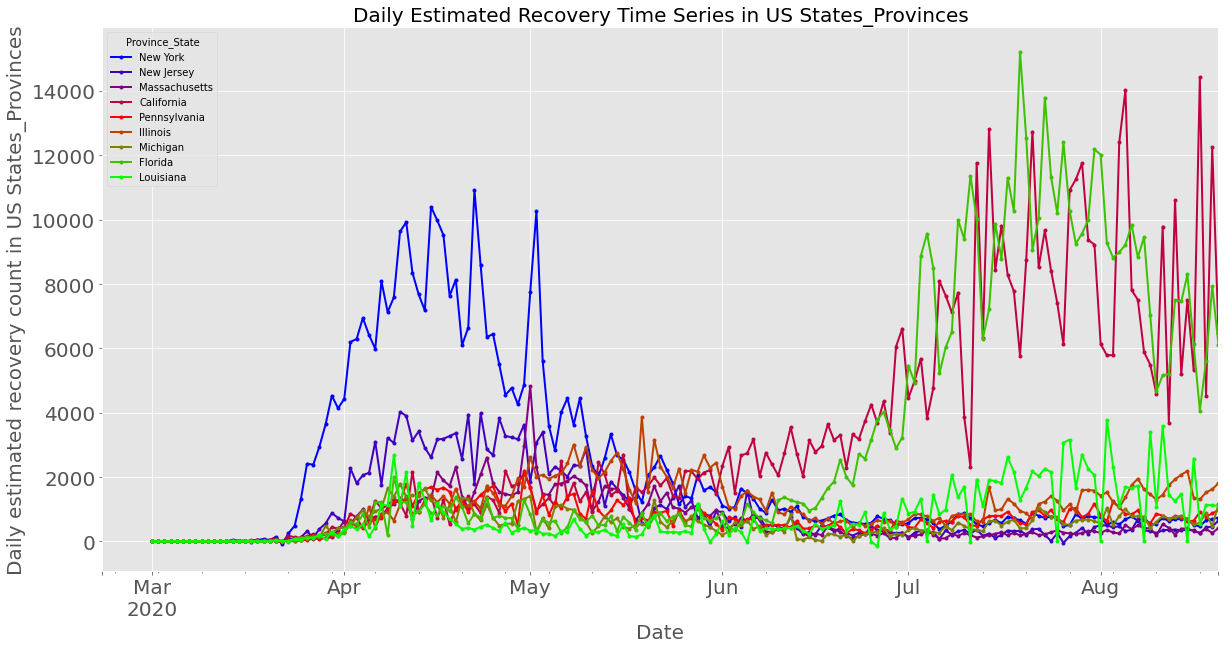

In [54]:
states_daily_recovery_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily estimated recovery count in US States_Provinces', fontsize=20);
plt.title('Daily Estimated Recovery Time Series in US States_Provinces', fontsize=20);  

In [55]:
#Estimated Active cases  =  Cumilative confirmed cases - Cumilative recovered cases - Cumilative deaths
states_active_df = states_confirmed_df.subtract(states_recovery_df).subtract(states_deaths_df)
states_active_df

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16,7099,548,0,6614,3282,64127,2515,577,876,0,467,40610,20434,0,84,1544,2981,12032,6087,3528,3223,3948,6519,124,4709,2553,5533,4254,4963,8813,798,1940,5075,153,2682,1093,4648,8606,991,2,7439,4776,1990,5758,3885,597,6062,669,10996,52066,2525,56,213,6601,4389,872,5187,236
2020-08-17,5984,535,0,6482,3049,55184,2331,700,902,0,466,39133,19836,0,159,1577,2833,12486,6014,3664,3431,4437,6524,146,4457,2526,5443,4200,4763,8866,775,1867,4995,164,2736,1056,4580,7954,934,5,7331,4748,1963,5426,3939,638,5794,697,10830,51529,2504,65,213,6672,4074,884,5135,289
2020-08-18,6510,552,0,6183,3076,59194,2190,571,894,0,429,37140,19089,0,150,1593,2723,12676,5985,3680,3406,4506,6000,161,4392,2356,5189,4253,4914,8615,742,1795,5119,156,2623,936,4568,8036,897,5,7084,4584,1902,5231,4310,639,5542,728,10855,51112,2405,58,220,6537,4112,859,4411,287
2020-08-19,6692,559,0,6114,3120,55898,2145,608,878,0,395,33146,17829,0,150,1651,2546,13327,5814,3550,3322,3981,5599,165,4265,2415,5402,4315,5181,8329,688,1796,4980,149,2489,933,4499,8186,998,5,6633,4525,1848,4987,3860,666,5437,751,11407,50656,2431,55,189,6498,3987,789,5230,345


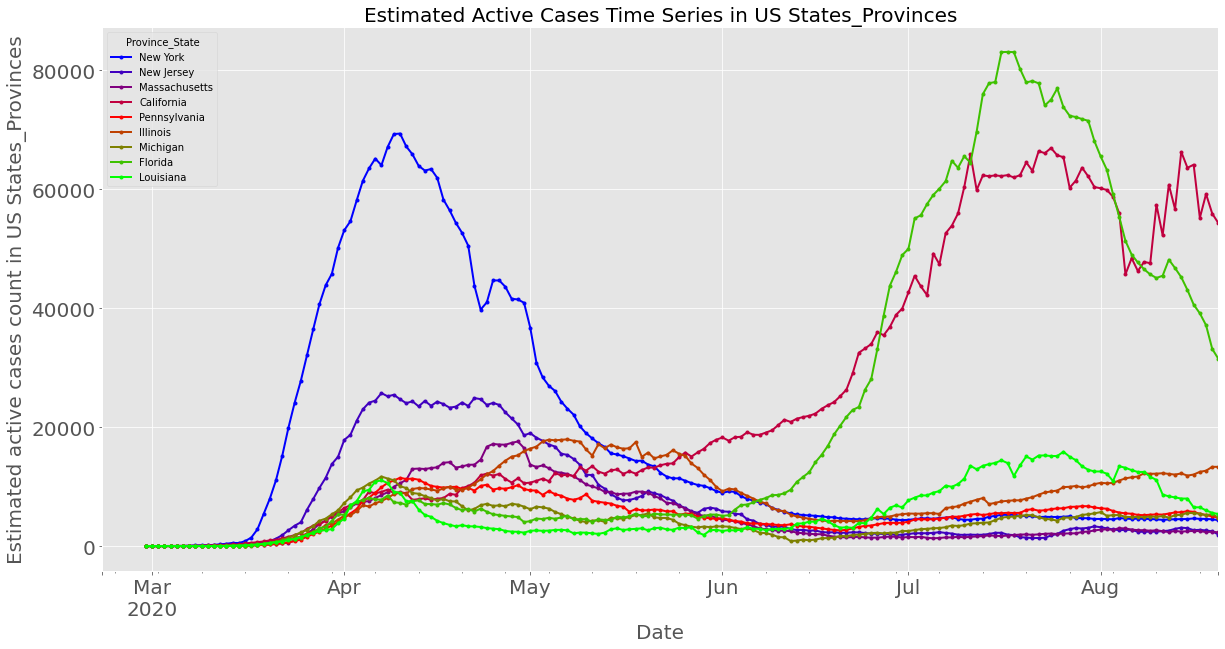

In [56]:
states_active_df[soi].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Estimated active cases count in US States_Provinces', fontsize=20);
plt.title('Estimated Active Cases Time Series in US States_Provinces', fontsize=20);  

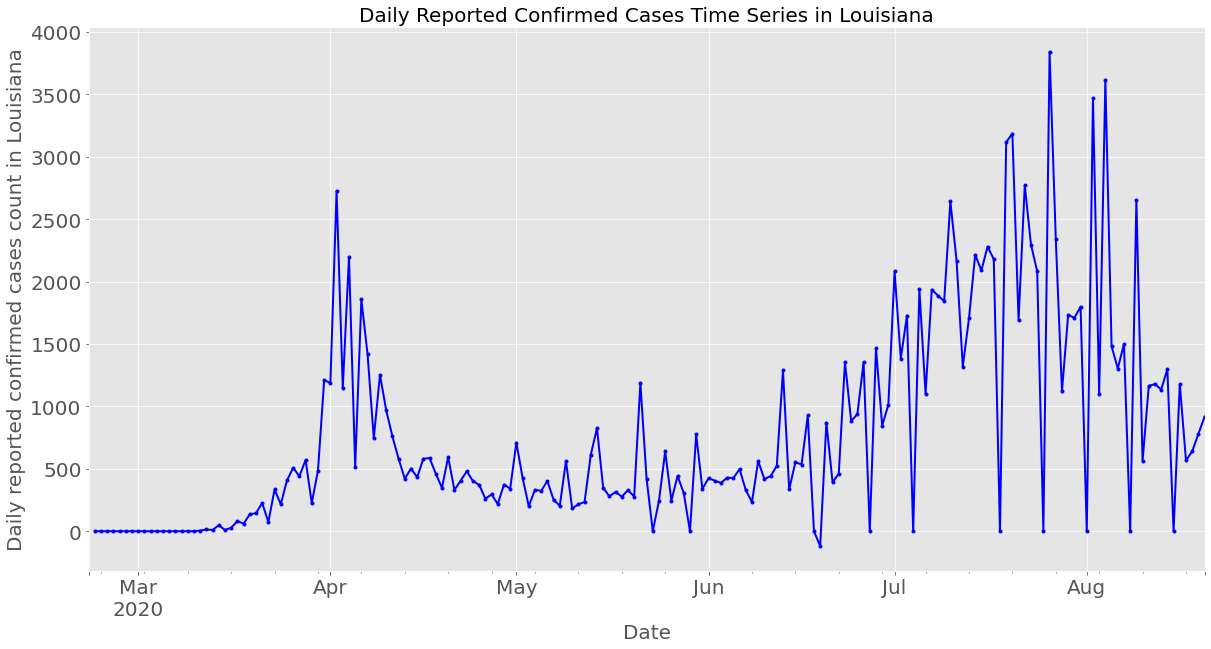

In [57]:
# Plot graphs for Louisiana
states_daily_confirmed_df['Louisiana'].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily reported confirmed cases count in Louisiana', fontsize=20);
plt.title('Daily Reported Confirmed Cases Time Series in Louisiana', fontsize=20); 

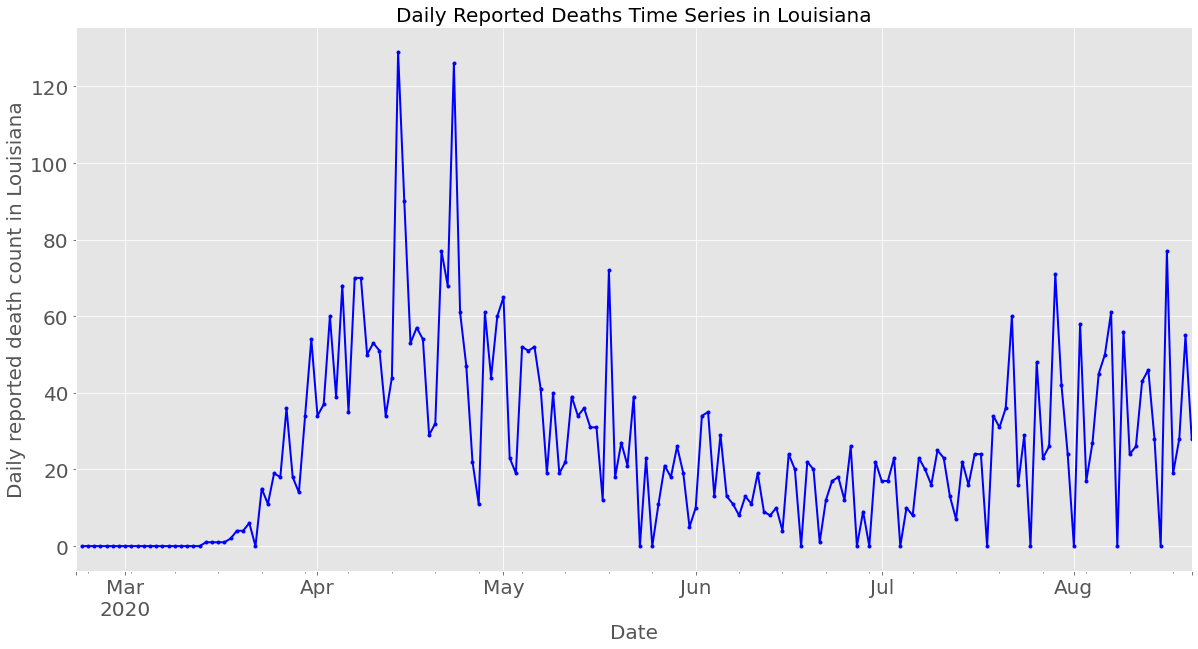

In [58]:
states_daily_deaths_df['Louisiana'].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily reported death count in Louisiana', fontsize=20);
plt.title('Daily Reported Deaths Time Series in Louisiana', fontsize=20); 

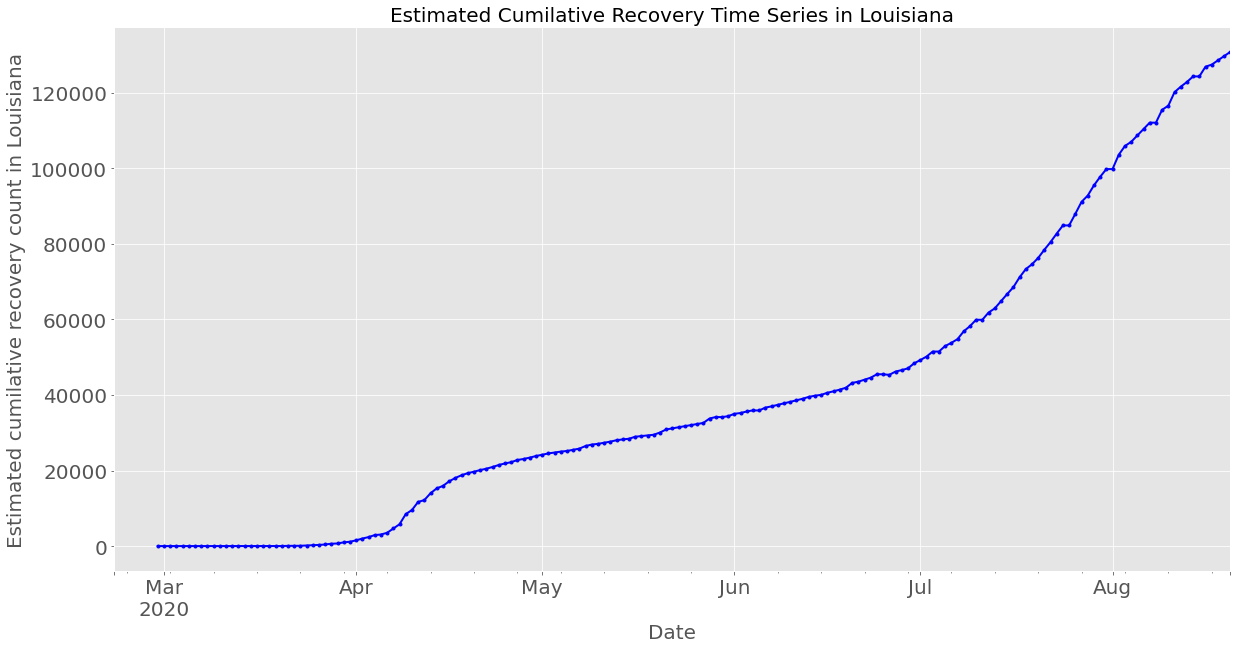

In [59]:
# Plot recovery for Louisiana
states_recovery_df['Louisiana'].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Estimated cumilative recovery count in Louisiana', fontsize=20);
plt.title('Estimated Cumilative Recovery Time Series in Louisiana', fontsize=20); 

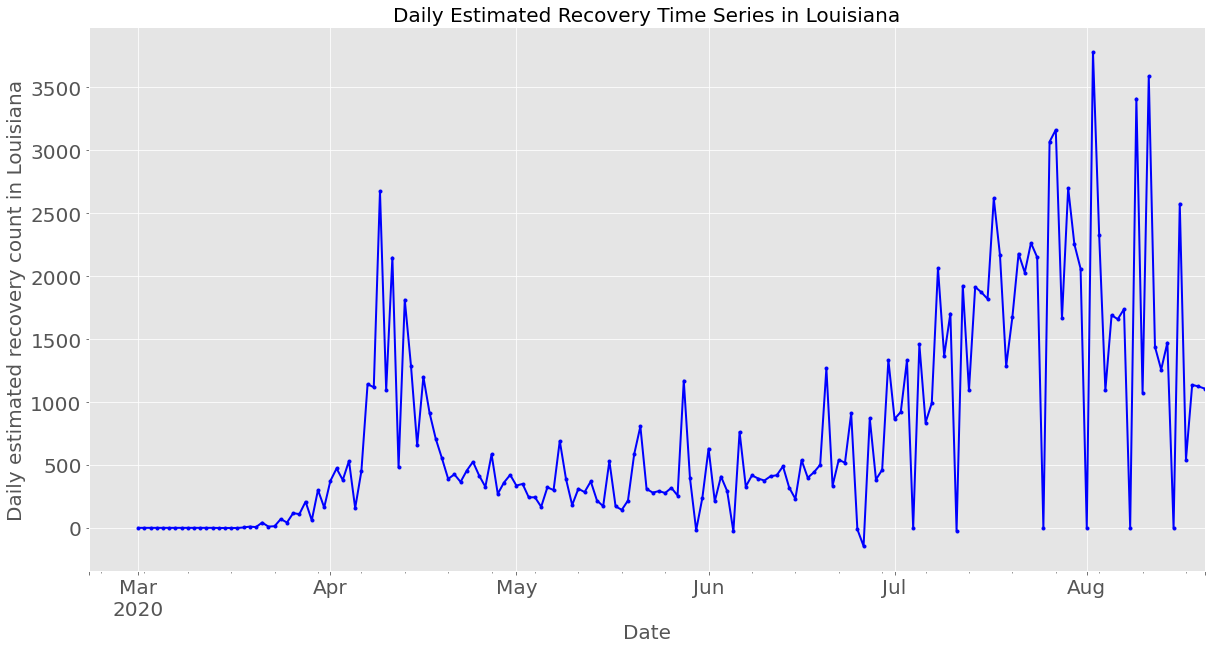

In [60]:
states_daily_recovery_df['Louisiana'].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Daily estimated recovery count in Louisiana', fontsize=20);
plt.title('Daily Estimated Recovery Time Series in Louisiana', fontsize=20);  

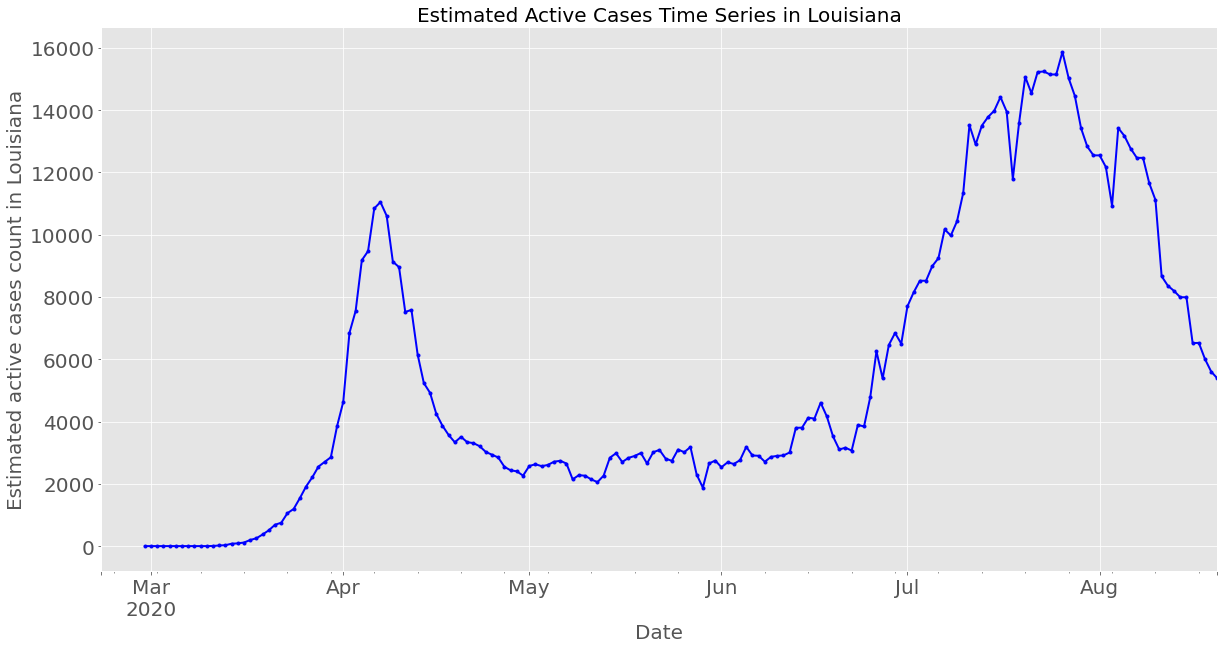

In [61]:
states_active_df['Louisiana'].plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Estimated active cases count in Louisiana', fontsize=20);
plt.title('Estimated Active Cases Time Series in Louisiana', fontsize=20);  

In [62]:
# louisiana_confirmed  = np.array(states_daily_confirmed_df['Louisiana']).reshape(-1, 1)
louisiana_confirmed  = np.array(states_confirmed_df['Louisiana']).reshape(-1, 1)

In [63]:
# X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_start2end[1:len(days_start2end)], louisiana_confirmed[1:len(louisiana_confirmed)], test_size=0.1, shuffle=False) 
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_start2end, louisiana_confirmed, test_size=0.1, shuffle=False) 

In [64]:
kernel = ['sigmoid','poly','rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()

In [32]:
svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())
svm_search.best_params_
svm_confirmed = svm_search.best_estimator_
# svm_pred_confirmed = svm_confirmed.predict(days_start2future[1:len(days_start2future)])
svm_pred_confirmed = svm_confirmed.predict(days_start2future)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


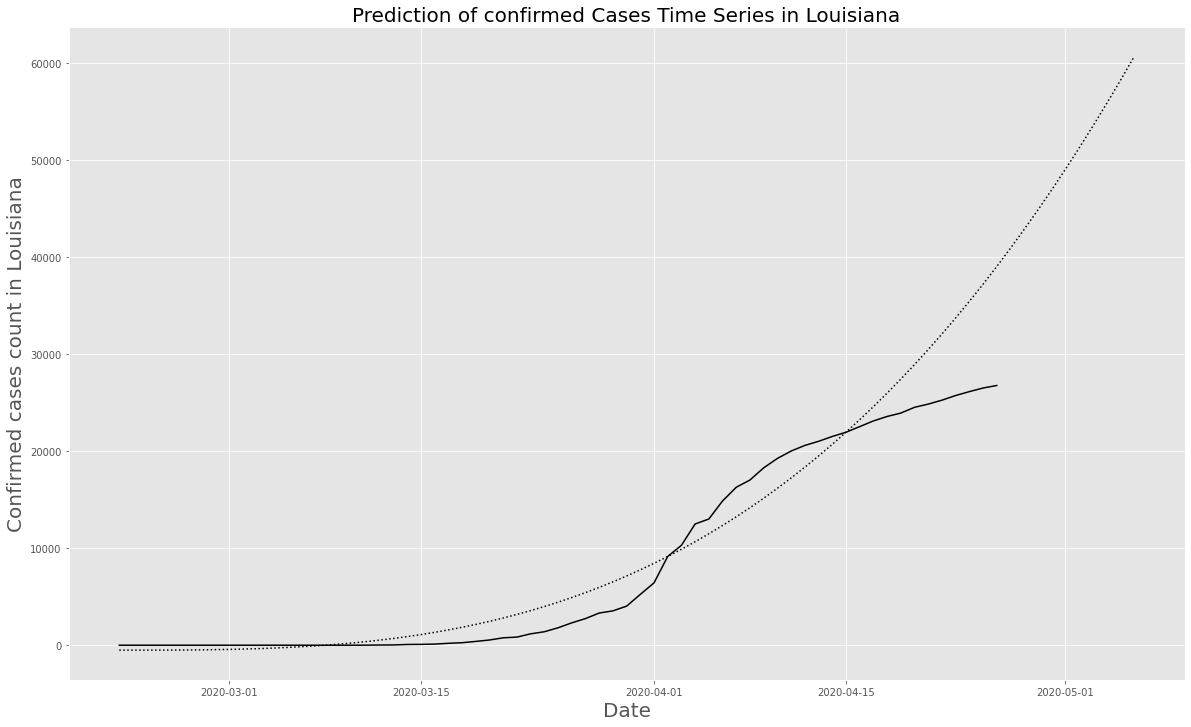

In [33]:
plt.figure(figsize=(20, 12))
plt.style.use('ggplot')
plt.plot(start2end_dates_array,louisiana_confirmed, color='black')
# plt.plot(start2future_dates_array[1:len(start2future_dates_array)], svm_pred_confirmed, linestyle='dotted', color='black')
plt.plot(start2future_dates_array, svm_pred_confirmed, linestyle='dotted', color='black')
plt.xlabel('Date', fontsize=20);
plt.ylabel('Confirmed cases count in Louisiana', fontsize=20);
plt.title('Prediction of confirmed Cases Time Series in Louisiana', fontsize=20);  